# Homework 2 - Course Completion Analysis & Prediction Using ML
### Sakka Mohamad-Mario `1241EB`

## 1. Introduction

In this homework I work with a dataset of students taking online courses. Each row is one student–course record, with columns describing the student, the course, and their behaviour on the platform. The main goal is to predict whether a student completes the course (Completed) or not, using the other variables as features.

I first explore and clean the data: I look at the structure, distributions, correlations, missing values, and class imbalance. Then I preprocess it by dropping identifiers and leaky or redundant features, handling missing values, encoding categorical variables, and scaling numerical ones where needed. After that, I apply the techniques learned from the labs, compare their performance on the labeled data, and finally use the best model to predict completion for students with missing Completed values.

## 2. Exploratory Data Analysis (EDA)

Importing All Necessary Libraries

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### 2.A. Describe the structure of the data: number of rows, columns, and data types.

Importing all necessary libraries

In [145]:
records = pd.read_csv("data.csv")

print("Table dimensions (n_rows, n_columns):", records.shape)

print("\nOverview of columns and types:")
records.info()

num_features = records.select_dtypes(include=["int64", "float64"]).columns
cat_features = records.select_dtypes(include=["object"]).columns

numeric_table = pd.DataFrame({
    "Feature": num_features,
    "Dtype": [records[d].dtype for d in num_features]
})

categorical_table = pd.DataFrame({
    "Feature": cat_features,
    "Dtype": [records[d].dtype for d in cat_features]
})

print("\nNumeric features table:")
print(numeric_table)

print("\nCategorical features table:")
print(categorical_table)


Table dimensions (n_rows, n_columns): (100000, 43)

Overview of columns and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          100000 non-null  object 
 1   Project_Grade                 100000 non-null  float64
 2   Enrollment_Date               100000 non-null  object 
 3   Procrastination_Index         100000 non-null  float64
 4   Completed                     75000 non-null   object 
 5   Notifications_Checked         100000 non-null  int64  
 6   Average_Session_Duration_Min  100000 non-null  float64
 7   Discussion_Participation      100000 non-null  int64  
 8   Age                           100000 non-null  int64  
 9   Payment_Amount                100000 non-null  int64  
 10  Peer_Interaction_Score        90685 non-null   float64
 11  App_Usage_Percentage  

As we can see in the output above, we've got *10K* rows, with *43* columns

For some features there's a lot of missing values. Most importantly, the `Completed` column is missing *25K* values, then we also have `Peer_Interaction_Percentage`, `Device_Type`, `Days_Since_Last_Login`, `Internet_Connection_Quality`, `City`.

### 2.B. Identify correlations between data

Here, we first choose the rows where `Completed` has values, then we generate the correlation heatmap to identify features which are strongly correlated to the completion of courses.

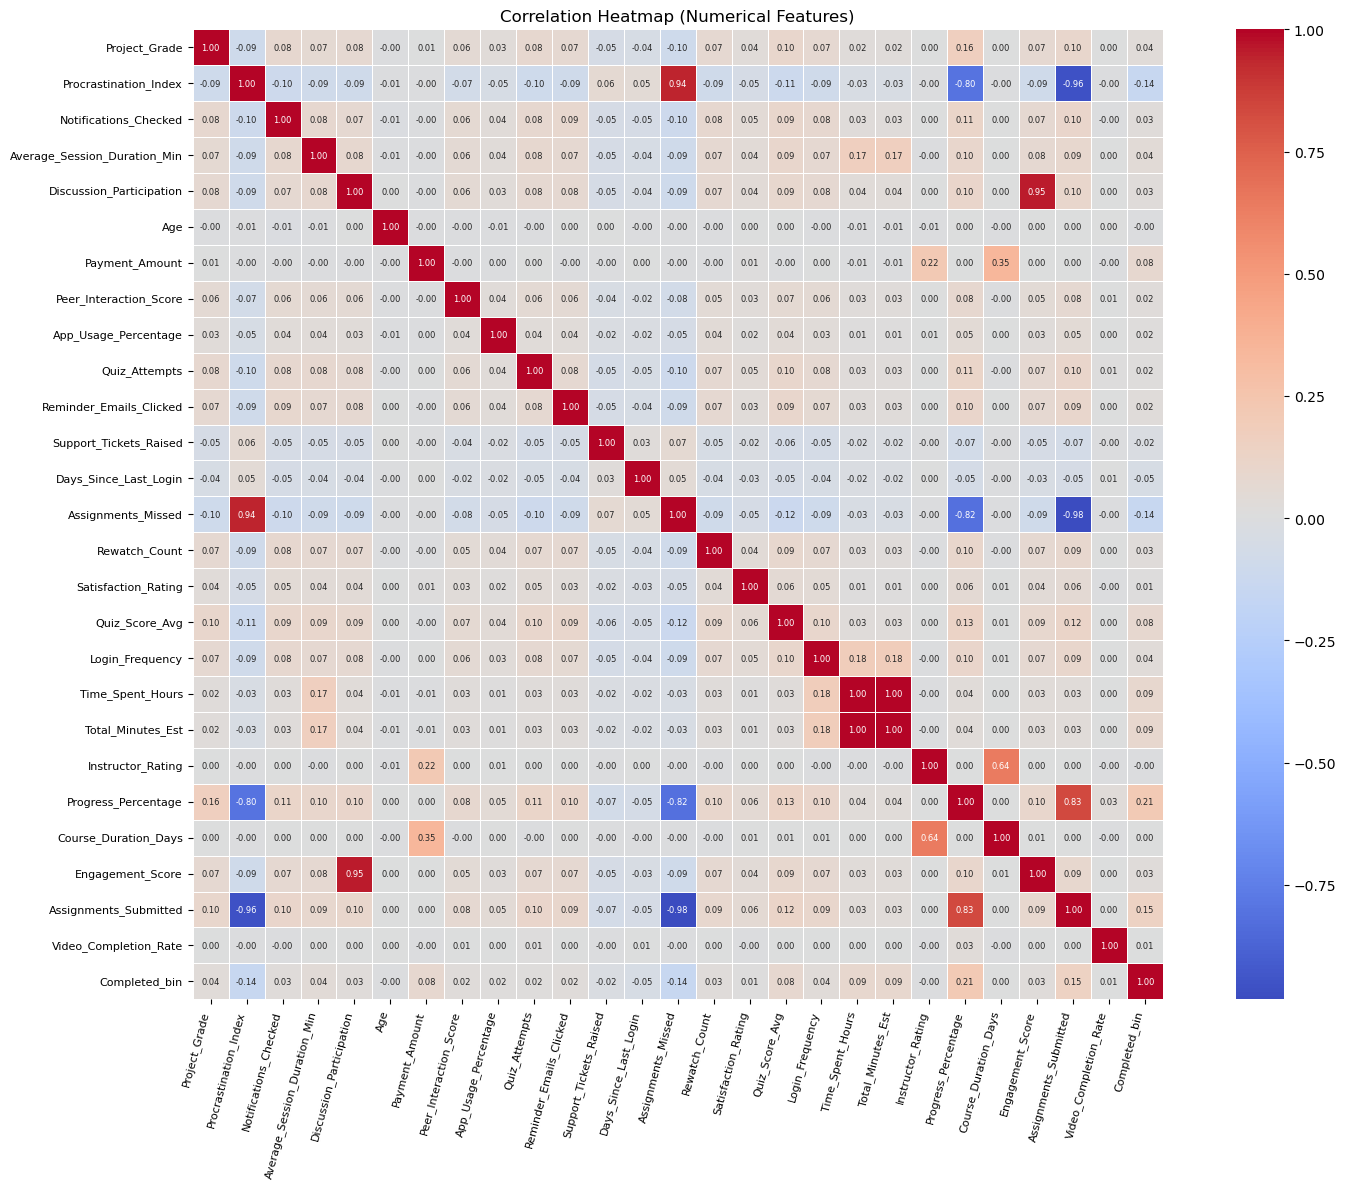

In [146]:
corr_records = records.dropna(subset=["Completed"]).copy()

corr_records["Completed_bin"] = (corr_records["Completed"] == "Completed").astype(int)

num_features_corr_records = corr_records.select_dtypes(include=["int64", "float64"]).columns

corr_mat = corr_records[num_features_corr_records].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_mat,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    annot_kws={"size": 6}
)

plt.title("Correlation Heatmap (Numerical Features)")
plt.xticks(rotation=75, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


This is a huge number of features, most of them having very little correlation with others. We also notice some strong, sensible correlations between multiple features. These are the biggest ones:

**The positive ones:**
- `Assignments_Missed <--> Procrastination_Index:` 0.94 - Students who miss more assignments tend to have a higher procrastination index.
- `Engagement_Score <--> Discussion_Participation:` 0.95 - Students with higher engagement scores tend to participate more in discussions.
- `Total_Minutes_Est <--> Time_Spent_Hours:` 1.00 - When the total estimated minutes for a course is higher, the time students spend on the platform also increases in a very consistent, almost one-to-one way. This tells us that one of these columns can be written as a simple transformation of the other, so they carry almost the same information. To avoid redundant features and keep the model simpler, we keep only one of them and drop the other from the dataset.
- `Assignments_Submitted <--> Progress_Percentage:` 0.83 - Students who submit more assignments tend to have a higher course progress percentages.
- `Course_Duration_Days <--> Instructor_Rating:` 0.64 - Longer courses are often associated with instructors who have higher ratings. 
- `Course_Duration_Days <--> Payment_Amount:` 0.35 - There is a weak tendency for more expensive courses to also last longer.

**The negative ones:**
- `Assignments_Submitted <--> Procrastination_Index:` -0.96 - Students with higher procrastination indices tend to submit less assignments.
- `Assignments_Submitted <--> Assignments_Missed:` -0.98 - Students who submit more assignments tend to miss less of them (obviously).
- `Progress_Percentage <--> Procrastination_Index:` -0.80 - Students with higher procrastination indices tend to have lower course progress percentages.
- `Progress_Percentage <--> Assignments_Missed:` -0.82 - Students who submit less assignments tend to have lower course progress percentages.

As we can see, none of the features seem to have strong correlations with the `Completed` feature.

After removing features that are either redundant or not very meaningful for this problem, we keep a subset of variables that look most relevant. Their correlations are shown in the map below:

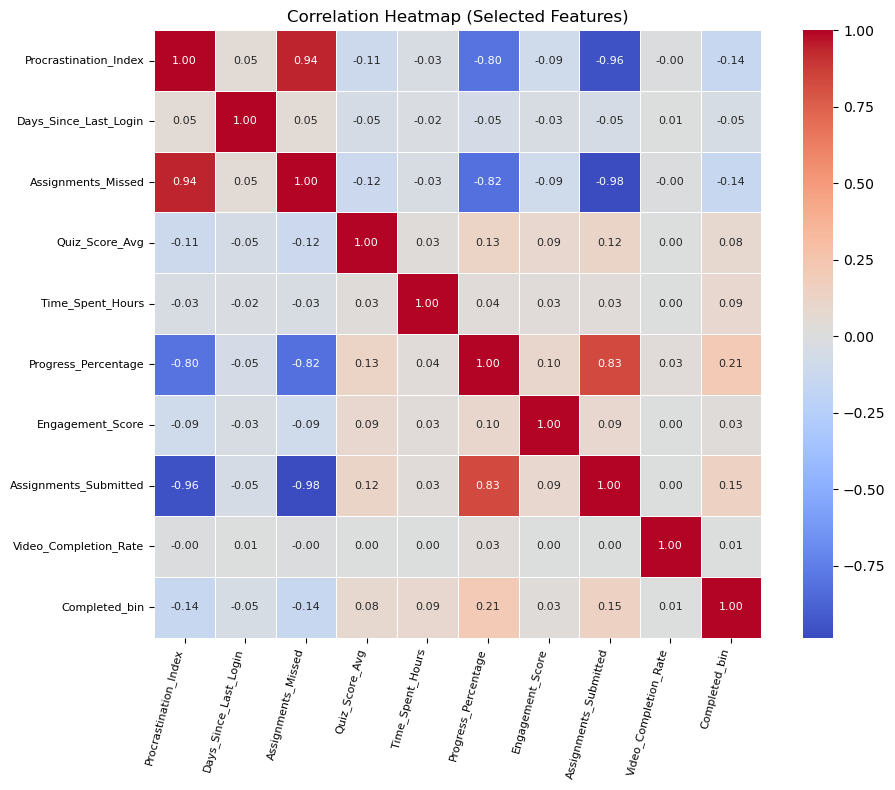

In [147]:
selected_features = [
    "Procrastination_Index",
    "Days_Since_Last_Login",
    "Assignments_Missed",
    "Quiz_Score_Avg",
    "Time_Spent_Hours",
    "Progress_Percentage",
    "Engagement_Score",
    "Assignments_Submitted",
    "Video_Completion_Rate",
    "Completed_bin",
]

selected_corr_mat = corr_records[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    selected_corr_mat,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title("Correlation Heatmap (Selected Features)")
plt.xticks(rotation=75, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

From the heatmap, we can see that the features most related to completion are:

- Positively: `Progress_Percentage`, `Assignments_Submitted`
- Negatively: `Assignments_Missed`, `Procrastination_Index`

These correlations are not very strong in absolute value, but compared to the rest of the features they stand out as the ones most closely associated with whether a student completes the course or not.

### 2.C. Make plots to show data distributions

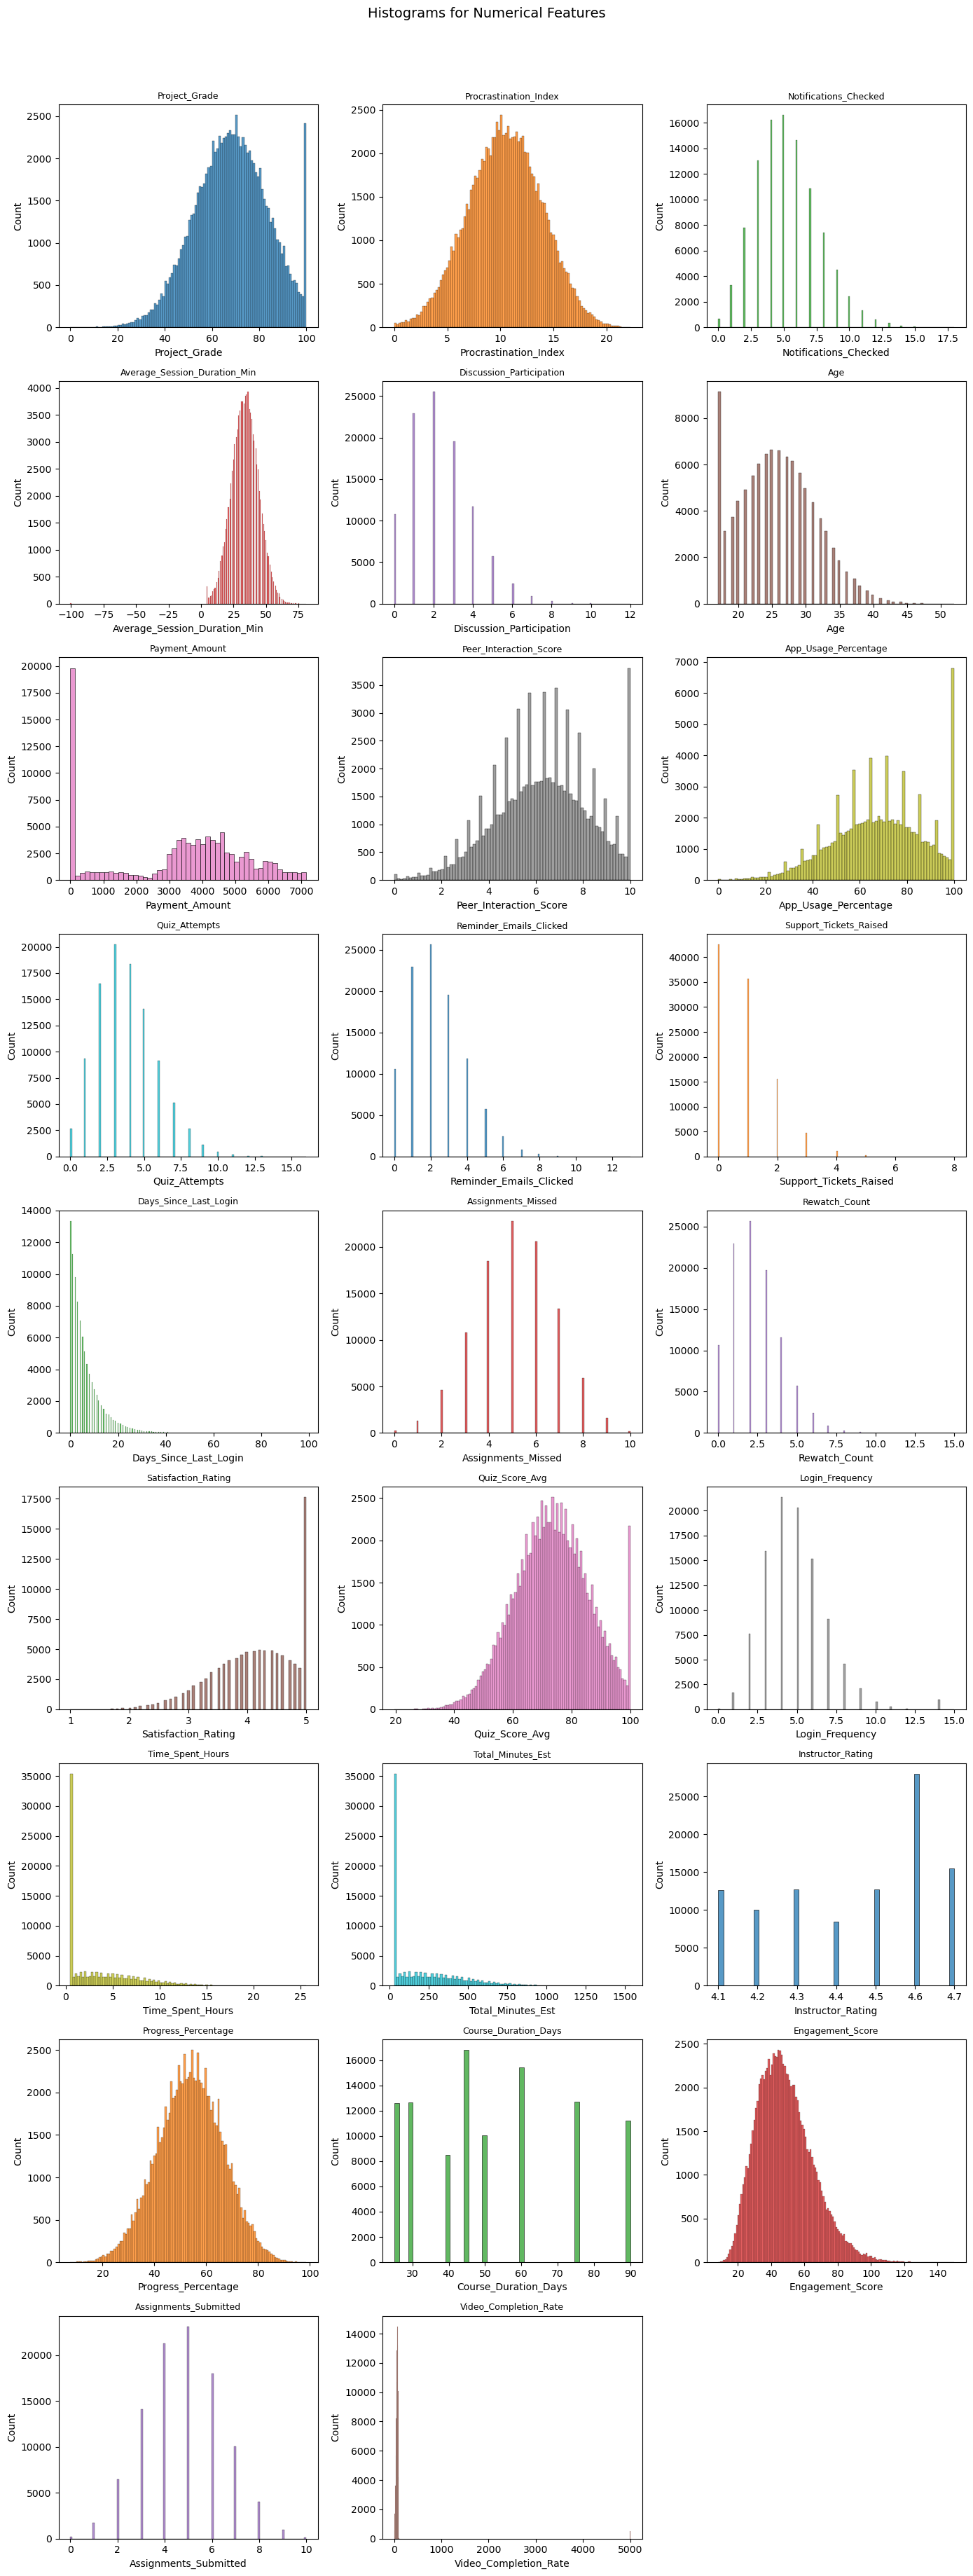

In [148]:
num_cols = list(num_features)
num_palette = sns.color_palette("tab10", len(num_cols))

cols_per_row = 3
rows_needed = int(np.ceil(len(num_cols) / cols_per_row))

plt.figure(figsize=(14, 4 * rows_needed))
for idx, feature in enumerate(num_cols):
    plt.subplot(rows_needed, cols_per_row, idx + 1)
    sns.histplot(
        data=records,
        x=feature,
        color=num_palette[idx % len(num_palette)]
    )
    plt.title(feature, fontsize=9)

plt.suptitle("Histograms for Numerical Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


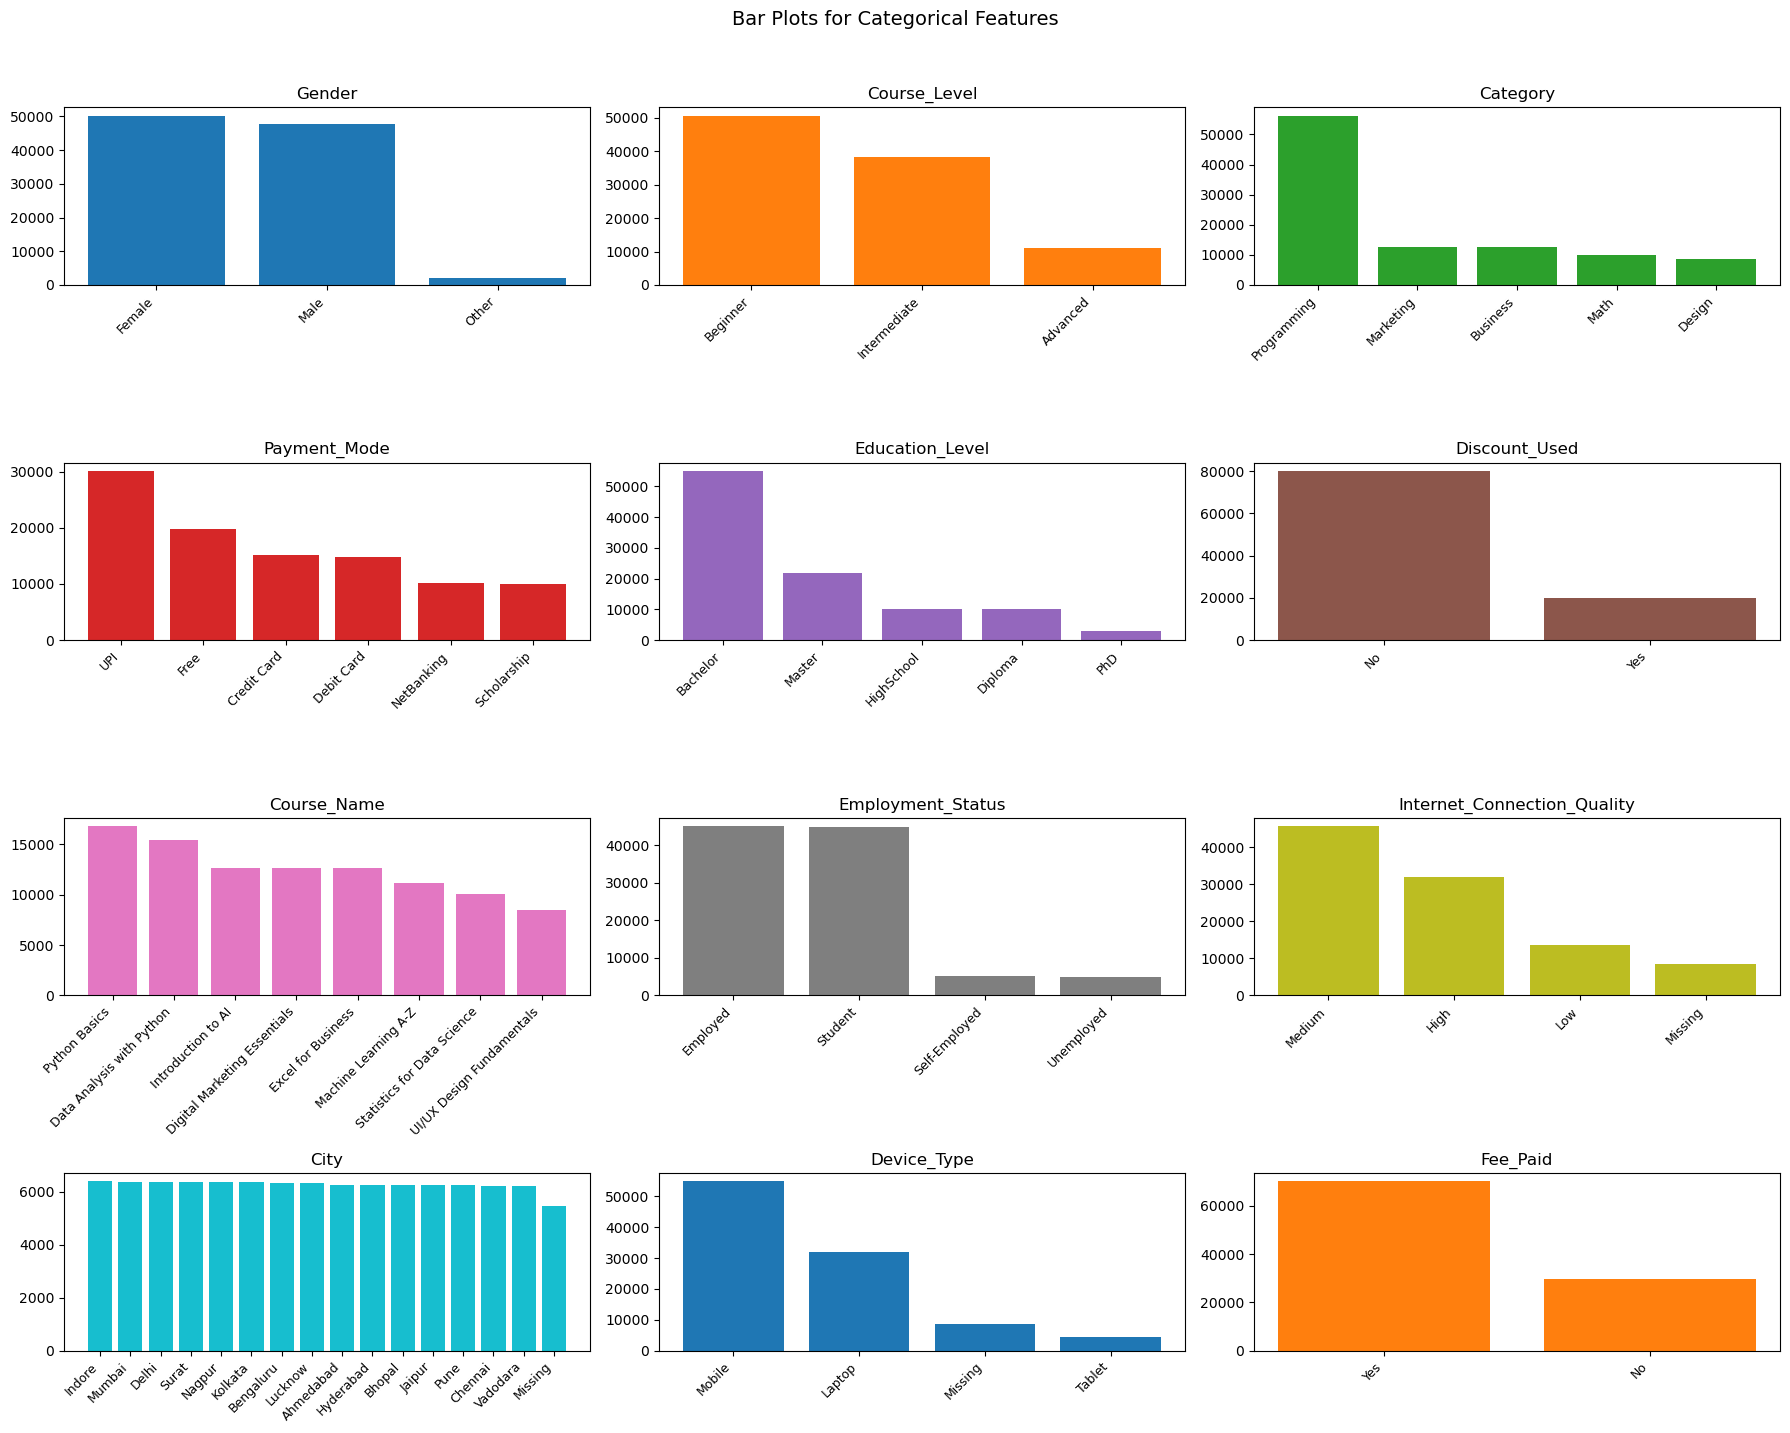

In [149]:
cat_cols_to_plot = [
    "Gender",
    "Course_Level",
    "Category",
    "Payment_Mode",
    "Education_Level",
    "Discount_Used",
    "Course_Name",
    "Employment_Status",
    "Internet_Connection_Quality",
    "City",
    "Device_Type",
    "Fee_Paid"
]

colors = sns.color_palette("tab10", len(cat_cols_to_plot))

cols_per_row = 3
rows_needed = int(np.ceil(len(cat_cols_to_plot) / cols_per_row))

plt.figure(figsize=(6 * cols_per_row, 3.5 * rows_needed))

for idx, feature in enumerate(cat_cols_to_plot):
    plt.subplot(rows_needed, cols_per_row, idx + 1)
    
    value_counts = records[feature].value_counts(dropna=False)
    
    labels = value_counts.index.to_series().astype(str)
    labels = labels.replace("nan", "Missing")
    
    plt.bar(labels, value_counts.values, color=colors[idx % len(colors)])
    plt.title(feature)
    plt.xticks(rotation=45, ha="right", fontsize=9)

plt.suptitle("Bar Plots for Categorical Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### 2.D. Identify target and feature variables

In [150]:
target_col = "Completed"

non_predictive_cols = [
    "Student_ID",
    "Name",
    "Enrollment_Date",
    "City"
]

predictive_cols = [
    col for col in records.columns
    if col not in non_predictive_cols + [target_col]
]

print(f"Target column: {target_col}")

print("\nFeature columns:")
pd.DataFrame({"Feature": predictive_cols})


Target column: Completed

Feature columns:


,Feature
0,Project_Grade
1,Procrastination_Index
2,Notifications_Checked
3,Average_Session_Duration_Min
4,Discussion_Participation
5,Age
6,Payment_Amount
7,Peer_Interaction_Score
8,App_Usage_Percentage
9,Quiz_Attempts


### 2.E. Highlight potential issues in the Data

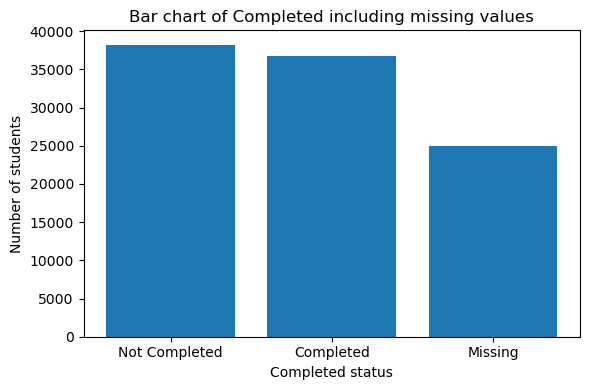

In [151]:

completed_counts = records["Completed"].value_counts(dropna=False)

labels = completed_counts.index.to_series().astype(str)
labels = labels.replace("nan", "Missing")

plt.figure(figsize=(6, 4))
plt.bar(labels, completed_counts.values)
plt.title("Bar chart of Completed including missing values")
plt.xlabel("Completed status")
plt.ylabel("Number of students")
plt.tight_layout()
plt.show()

We can already see several issues in the dataset from the bar plot of `Completed` and the previous exploratory analysis:

1. A large part of the target column is missing: around 25% of the rows do not have a `Completed` label. I cannot use these rows directly for supervised training.

2. There is a small class imbalance in the labeled part of `Completed`: there are more “Not Completed” than “Completed” students, with a difference of roughly 1,000 examples. This is not extreme, but it can still slightly bias some models.

3. Other features also contain missing values: `Days_Since_Last_Login`, `Peer_Interaction_Score`, `Device_Type` and `Internet_Connection_Quality`, so I will need to decide how to fill or handle those.

4. All categorical features must be encoded into numerical form (for example with one hot encoding) before I can combine them with numerical features in a machine learning model.

5. Some features are highly redundant. For example, `Total_Minutes_Est` is almost perfectly correlated with `Time_Spent_Hours`, this means they carry very similar information, so I will need to drop at least one of them to avoid unnecessary duplication in the feature set.


## 3. Data Processing

In [ ]:
non_predictive_cols = [
    "Student_ID",
    "Name",
    "Enrollment_Date",
    "City"
]

predictive_cols = [
    col for col in records.columns
    if col not in non_predictive_cols + [target_col]
]

X = records[predictive_cols].copy()

numeric_predictive_cols = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_predictive_cols = list(X.select_dtypes(include=["object", "category"]).columns)

Y = records["Completed"].copy()

### 3.A. Identify outliers

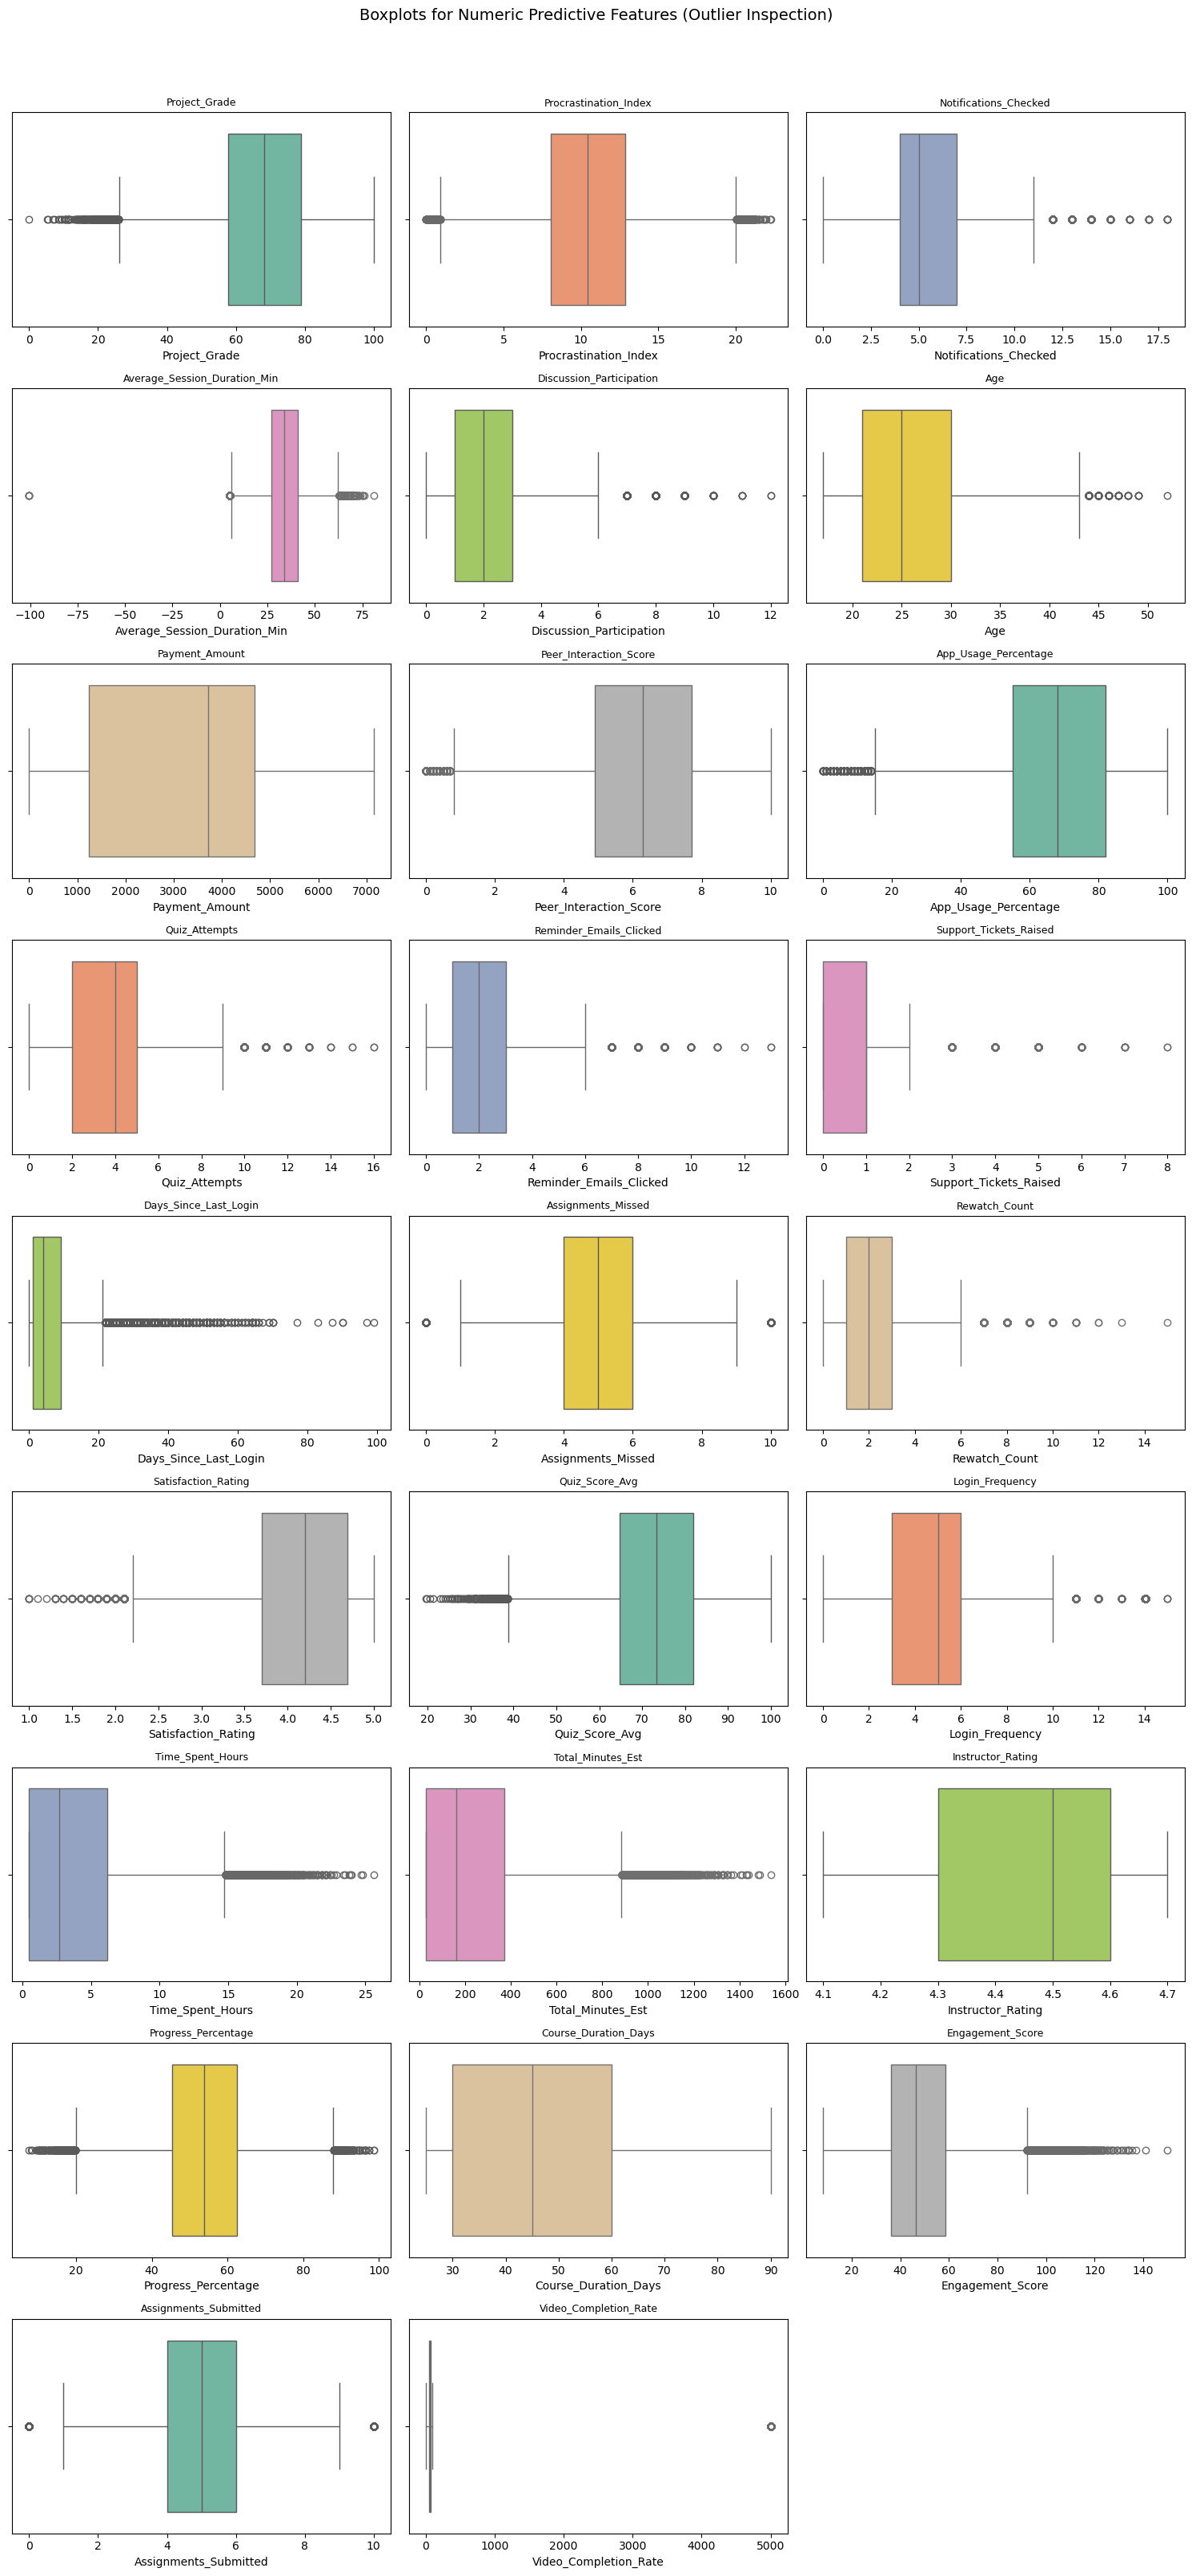

In [153]:

plots_per_row = 3
rows_needed = int(np.ceil(len(numeric_predictive_cols) / plots_per_row))

palette = sns.color_palette("Set2", len(numeric_predictive_cols))

plt.figure(figsize=(5 * plots_per_row, 3.5 * rows_needed))

for idx, col in enumerate(numeric_predictive_cols):
    plt.subplot(rows_needed, plots_per_row, idx + 1)
    sns.boxplot(data=X, x=col, color=palette[idx])
    plt.title(col, fontsize=9)

plt.suptitle("Boxplots for Numeric Predictive Features (Outlier Inspection)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


The boxplots show that most numeric features have plausible ranges but several contain clear outliers. In particular, `Average_Session_Duration_Min` has a few negative values, and `Video_Completion_Rate` includes extremely large, likely erroneous values. Several engagement variables (`Days_Since_Last_Login`, `Engagement_Score`, `Rewatch_Count`, `Quiz_Attempts`, etc.) are strongly right-skewed, with a small number of students showing very high values on these measures. The following code will correct or cap obvious data errors and consider standard scaling for heavily skewed features.

Replaced 5 negative values in 'Average_Session_Duration_Min' with median 34.00.
Clipped 'Video_Completion_Rate' from range [5.00, 5000.00] to [5.00, 100.00].


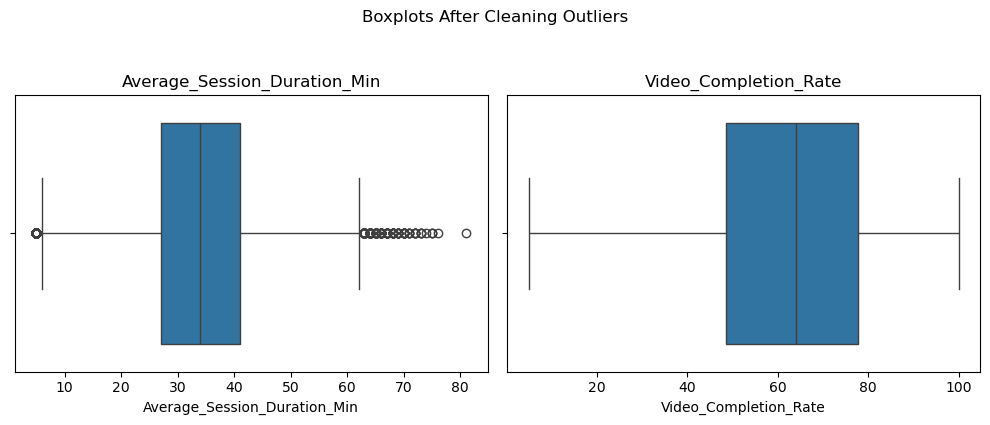

In [154]:
sess_col = "Average_Session_Duration_Min"
vcr_col = "Video_Completion_Rate"

if sess_col in numeric_predictive_cols:
    neg_mask = X[sess_col] < 0
    n_neg = neg_mask.sum()

    if n_neg > 0:
        median_sess = X.loc[~neg_mask, sess_col].median()
        X.loc[neg_mask, sess_col] = median_sess
        print(f"Replaced {n_neg} negative values in '{sess_col}' with median {median_sess:.2f}.")
    else:
        print(f"No negative values found in '{sess_col}'.")
else:
    print(f"'{sess_col}' is not in predictive_cols, skipping.")

if vcr_col in numeric_predictive_cols:
    before_min, before_max = X[vcr_col].min(), X[vcr_col].max()
    X.loc[:, vcr_col] = X[vcr_col].clip(lower=0, upper=100)
    after_min, after_max = X[vcr_col].min(), X[vcr_col].max()
    print(
        f"Clipped '{vcr_col}' from range [{before_min:.2f}, {before_max:.2f}] "
        f"to [{after_min:.2f}, {after_max:.2f}]."
    )
else:
    print(f"'{vcr_col}' is not in predictive_cols, skipping.")


plt.figure(figsize=(10, 4))
for i, col in enumerate([sess_col, vcr_col], start=1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=X[col])
    plt.title(col)
plt.suptitle("Boxplots After Cleaning Outliers", y=1.05)
plt.tight_layout()
plt.show()

### 3.B. Deal with missing values

We handle missing values only in the predictive feature matrix X. For numeric features, we replace missing entries with the feature median, and for categorical features we impute missing values with the most frequent category (mode).

In [155]:
missing_before = X.isna().sum()


impute_info = []

for col in numeric_predictive_cols:
    n_missing = X[col].isna().sum()
    if n_missing > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        impute_info.append({
            "Feature": col,
            "Imputation_strategy": "Median",
            "Imputation_value": median_val
        })

for col in categorical_predictive_cols:
    n_missing = X[col].isna().sum()
    if n_missing > 0:
        mode_val = X[col].mode().iloc[0]
        X[col] = X[col].fillna(mode_val)
        impute_info.append({
            "Feature": col,
            "Imputation_strategy": "Mode",
            "Imputation_value": mode_val
        })

missing_after = X.isna().sum()

summary_rows = []
for info in impute_info:
    col = info["Feature"]
    summary_rows.append({
        "Feature": col,
        "Missing_before": int(missing_before[col]),
        "Missing_after": int(missing_after[col]),
        "Imputation_strategy": info["Imputation_strategy"],
        "Imputation_value": info["Imputation_value"],
    })

missing_summary = pd.DataFrame(summary_rows).set_index("Feature").sort_values(
    "Missing_before", ascending=False
)

print("Missing values in X: BEFORE vs AFTER imputation")
display(missing_summary)


Missing values in X: BEFORE vs AFTER imputation


,Missing_before,Missing_after,Imputation_strategy,Imputation_value
Feature,,,,
Peer_Interaction_Score,9315,0,Median,6.3
Device_Type,8661,0,Mode,Mobile
Internet_Connection_Quality,8534,0,Mode,Medium
Days_Since_Last_Login,7472,0,Median,4.0


### 3.C. Deal with categorical data

In [ ]:
cols_to_drop = ["Name", "Student_ID", "Course_Name", "Enrollment_Date",
                "Fee_Paid", "Payment_Mode", "City", "Discount_Used"]
cols_to_drop = [c for c in cols_to_drop if c in X.columns]

X = X.drop(columns=cols_to_drop)

dropped_df = pd.DataFrame({"Dropped_feature": cols_to_drop})
print("Columns removed from X (ID / context / non-predictive):")
display(dropped_df)

numeric_predictive_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_predictive_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

cat_df = pd.DataFrame({"Categorical_predictive_feature": categorical_predictive_cols})
print("Categorical predictive features (to be one-hot encoded):")
display(cat_df)

shape_before = X.shape
X_encoded = pd.get_dummies(X, columns=categorical_predictive_cols, drop_first=True)

# update this list of categorical predictive cols that I've defined at the start of section 3
categorical_predictive_cols = [
    "Device_Type",
    "Gender",
    "Internet_Connection_Quality",
    "Course_Level",
    "Employment_Status",
    "Education_Level",
    "Course_ID",
    "Category",
]

shape_after = X_encoded.shape

shape_df = pd.DataFrame([
    {"Stage": "Before encoding", "n_rows": shape_before[0], "n_features": shape_before[1]},
    {"Stage": "After encoding",  "n_rows": shape_after[0],  "n_features": shape_after[1]},
])
print("Shape of X before and after one-hot encoding:")
display(shape_df)

Y_encoded = Y.map({
    "Completed": 1,
    "Not Completed": 0
})

y_counts = Y_encoded.value_counts(dropna=False).rename_axis("Y_value").reset_index(name="Count")
y_counts["Proportion"] = (y_counts["Count"] / len(Y_encoded)).round(4)

print("Distribution of Y (including missing labels):")
display(y_counts)


Columns removed from X (ID / context / non-predictive):


,Dropped_feature
0,Course_Name
1,Fee_Paid
2,Payment_Mode
3,Discount_Used


Categorical predictive features (to be one-hot encoded):


,Categorical_predictive_feature
0,Device_Type
1,Gender
2,Internet_Connection_Quality
3,Course_Level
4,Employment_Status
5,Education_Level
6,Course_ID
7,Category


Shape of X before and after one-hot encoding:


,Stage,n_rows,n_features
0,Before encoding,100000,34
1,After encoding,100000,52


Distribution of Y (including missing labels):


,Y_value,Count,Proportion
0,0.0,38193,0.3819
1,1.0,36807,0.3681
2,NaN,25000,0.2500


I have removed features that are pure identifiers, high-cardinality and not very meaningful, redundant, or mostly about payment and platform details rather than student learning:

- **Name**  
  This is a pure identifier of the student. It does not generalize and it is not something I can use to explain why a student completed a course. I dropped it.

- **Student_ID**  
  This is also a pure identifier. It only distinguishes one student from another and does not contain general behaviour patterns. I dropped it.

- **City**  
  This column has many possible values and mainly describes where the student lives, which is not central to their learning behaviour. It would add many sparse dummy columns without clear benefit, so I drop `City` to keep the feature set simpler and more focused.

- **Enrollment_Date**  
  This is effectively a timestamp of when the student joined. It can be useful if I engineer features such as seasonality or time since enrollment, but as a raw categorical value it is very high cardinality and not very meaningful. I dropped it.

- **Course_Name and Course_ID**  
  These two columns essentially describe the same thing, the course that the student is taking. Keeping both would be redundant.  
  I choose to **drop `Course_Name` and keep `Course_ID`**, and I will encode `Course_ID` as a categorical feature. This way I still let the model learn course specific patterns without doubling the number of features.

- **Payment_Mode**  
  The way someone pays is not really about their learning behaviour. It might correlate with marketing campaigns or pricing, but it is not central to the educational outcome and it might overfit to patterns that will not hold in the future. I dropped it.

- **Fee_Paid**  
  To keep the prediction task more realistic and to encourage the model to rely on engagement and profile features rather than payment status, I decide to drop `Fee_Paid` from the feature set.

- **Total_Minutes_Est**  
  It describes course length, but it is almost perfectly overlapping with `Time_Spent_Hours`. Since it does not bring much new information and mainly duplicates existing time and duration features, I drop `Total_Minutes_Est` to avoid redundancy and keep the feature set simpler.
- **Discount_Used**  
  It reflects marketing and pricing choices rather than learning behaviour, and it only has a weak link to completion. To avoid the model relying on platform-specific discount patterns instead of genuine engagement signals, I drop `Discount_Used` from the features.

After these choices, I am left with features that describe the student profile, course characteristics in a general way, and engagement behaviour, without obvious identifiers or strong leakage of the target.


### 3.D. Standardize or normalize numerical features as needed

### 3.E. Use principal component analysis (PCA)

## 4. Deal With Data Imbalance (2 Methods)

### 4.A. First method: **SMOTE**

### 4.B. Second method: **Undersampling**

## 5. Test 5 Different ML Methods and Print Performance Metrics

## 6. Conclusion: Summary of Findings, Best-Performing Model, and Future Improvements